# Intro to Object Detection Colab

Welcome to the object detection colab!  This demo will take you through the steps of running an "out-of-the-box" detection model on a collection of images.

## Imports and Setup

In [1]:
!pip install -U --pre tensorflow=="2.2.0"

Requirement already up-to-date: tensorflow==2.2.0 in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2796, done.
remote: Counting objects: 100% (2796/2796), done.
remote: Compressing objects: 100% (2435/2435), done.
remote: Total 2796 (delta 557), reused 1427 (delta 325), pack-reused 0
Receiving objects: 100% (2796/2796), 57.74 MiB | 35.00 MiB/s, done.
Resolving deltas: 100% (557/557), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1526915 sha256=d01e915c4e4a23279c90acbf5df2e7a2e173c96e43ebf71dc7bb69f118d0c2e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-fillnbod/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20069 sha256=2fd3d49c64a1c5e5a3524bf53794021cb02159a7a391acd43868a8bd9c657f36
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built object-detection py-cpuinfo
  Found existing installation: typing 3.6.6
    Uninstalling typing-3.6.6:
      Successfully uninstalled typing-3.6.6


object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.
ERROR: chainer 6.5.0 has requirement typing<=3.6.6, but you'll have typing 3.7.4.1 which is incompatible.


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Utilities

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [3]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'center_net_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'center_net_hg104_512x512_coco17_tpu-8'}

model_display_name = 'centernet_with_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

### Build a detection model and load pre-trained model weights

This sometimes takes a little while, please be patient!

In [4]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

if model_display_name == 'centernet_with_keypoints':
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
else:
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-07-12 10:26:31--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.198.48, 2a00:1450:4002:802::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.198.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453232297 (1,4G) [application/x-tar]
Saving to: ‘centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz’

centernet_hg104_512 100%[===================>]   1,35G  2,55MB/s    in 8m 29s  

2020-07-12 10:35:01 (2,72 MB/s) - ‘centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz’ saved [1453232297/1453232297]



In [6]:
import os 
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/',
                                'center_net_hourglass104_512x512_coco17_tpu-8' + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

# Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [7]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap('models/research/object_detection/data/mscoco_complete_label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### Putting everything together!

Run the below code which loads an image, runs it through the detection model and visualizes the detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be faster.

Here are some simple things to try out if you are curious:
* Try running inference on your own images (local paths work)
* Modify some of the input images and see if detection still works.  Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set min_score_thresh to other values (between 0 and 1) to allow more detections in or to filter out more detections.

Note that you can run this cell repeatedly without rerunning earlier cells.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


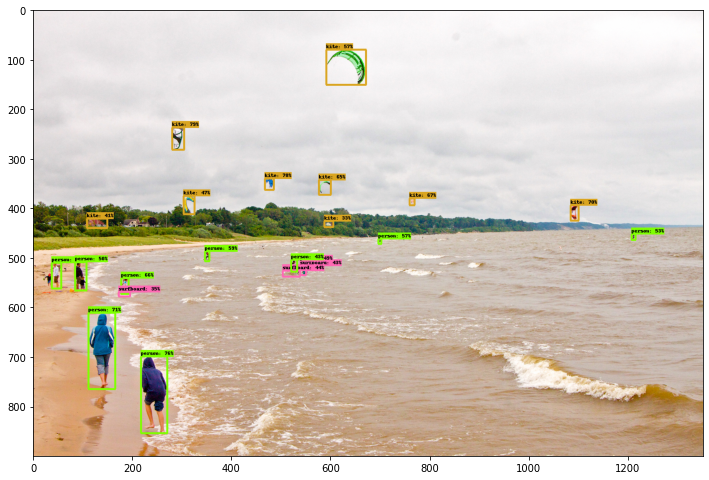

In [8]:
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

## Digging into the model's intermediate predictions

For this part we will assume that the detection model is a CenterNet model following Zhou et al (https://arxiv.org/abs/1904.07850).  And more specifically, we will assume that `detection_model` is of type `meta_architectures.center_net_meta_arch.CenterNetMetaArch`.

As one of its intermediate predictions, CenterNet produces a heatmap of box centers for each class (for example, it will produce a heatmap whose size is proportional to that of the image that lights up at the center of each, e.g., "zebra"). In the following, we will visualize these intermediate class center heatmap predictions.

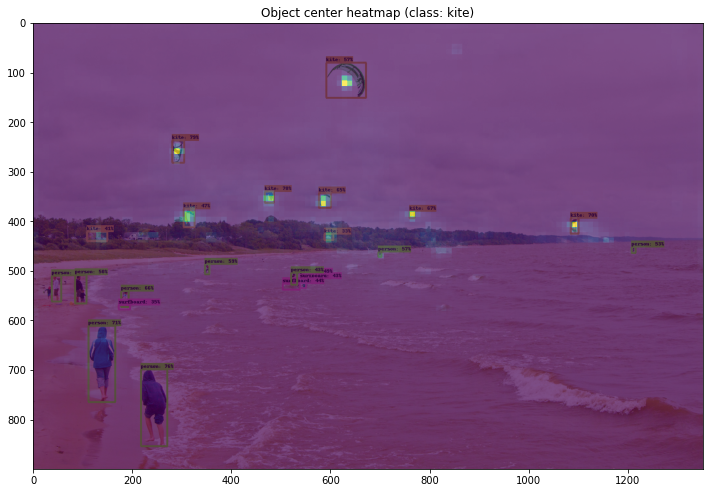

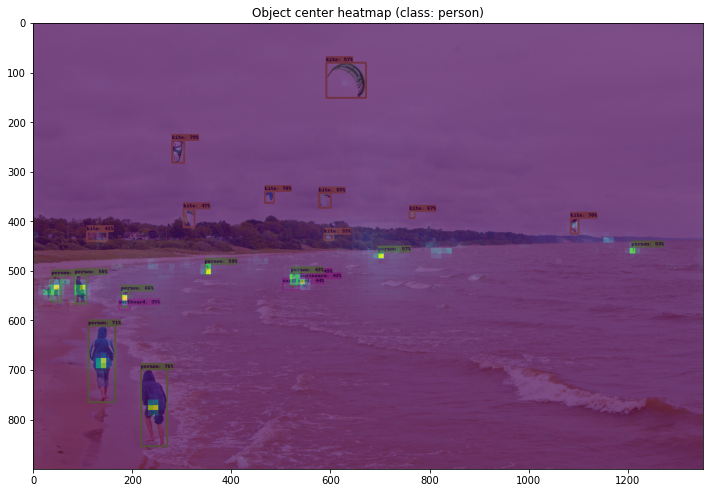

In [9]:
if detection_model.__class__.__name__ != 'CenterNetMetaArch':
  raise AssertionError('The meta-architecture for this section '
  'is assumed to be CenterNetMetaArch!')

def get_heatmap(predictions_dict, class_name):
  """Grabs class center logits and apply inverse logit transform.

  Args:
    predictions_dict: dictionary of tensors containing a `object_center`
      field of shape [1, heatmap_width, heatmap_height, num_classes]
    class_name: string name of category (e.g., `horse`)

  Returns:
    heatmap: 2d Tensor heatmap representing heatmap of centers for a given class
      (For CenterNet, this is 128x128 or 256x256) with values in [0,1]
  """
  class_index = label_map_dict[class_name]
  class_center_logits = predictions_dict['object_center'][0]
  class_center_logits = class_center_logits[0][
    :, :, class_index - label_id_offset]
  heatmap = tf.exp(class_center_logits) / (tf.exp(class_center_logits) + 1)
  return heatmap

def unpad_heatmap(heatmap, image_np):
  """Reshapes/unpads heatmap appropriately.

  Reshapes/unpads heatmap appropriately to match image_np.

  Args:
    heatmap: Output of `get_heatmap`, a 2d Tensor
    image_np: uint8 numpy array with shape (img_height, img_width, 3).  Note
      that due to padding, the relationship between img_height and img_width
      might not be a simple scaling.

  Returns:
    resized_heatmap_unpadded: a resized heatmap (2d Tensor) that is the same
      size as `image_np`
  """
  heatmap = tf.tile(tf.expand_dims(heatmap, 2), [1, 1, 3]) * 255
  pre_strided_size = detection_model._stride * heatmap.shape[0]
  resized_heatmap = tf.image.resize(
      heatmap, [pre_strided_size, pre_strided_size],
      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  resized_heatmap_unpadded = tf.slice(resized_heatmap, begin=[0,0,0], size=shapes)
  return tf.image.resize(
      resized_heatmap_unpadded,
      [image_np.shape[0], image_np.shape[1]],
      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,0]


class_name = 'kite'
heatmap = get_heatmap(predictions_dict, class_name)
resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np)
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
plt.title('Object center heatmap (class: ' + class_name + ')')
plt.show()

class_name = 'person'
heatmap = get_heatmap(predictions_dict, class_name)
resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np)
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
plt.title('Object center heatmap (class: ' + class_name + ')')
plt.show()